In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('emails.csv')

In [3]:
df.head(5)

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [4]:
df['Email No.'].is_unique

True

In [5]:
df = df.drop(columns=['Email No.'])

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler#, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [54]:
X= df.drop(columns='Prediction')
y= df['Prediction']

7 Classification models will be compared. RandomForest and ADABoost are tested with more estimators to further evaluation of data. SVM is compared using Linear kernel vs. Sigmoid kernel.

In [20]:
classifiers = {
    'LGBM': LGBMClassifier(verbose=0),
    'CatBoost':CatBoostClassifier(silent=True),
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RandomForest100': RandomForestClassifier(),
    'RandomForest200': RandomForestClassifier(n_estimators=200),
    'SVMLinear': SVC(kernel='linear', probability=True),
    'SVMSigmoid': SVC(kernel='sigmoid', probability=True),
    'GradientBoost': GradientBoostingClassifier(),
    'ADABoost100': AdaBoostClassifier(n_estimators=100),
    'ADABoost200': AdaBoostClassifier(n_estimators=200),
}

In [80]:
def sc_pca_class_test(X, y, scaler, reduce, components, ts, classifier, split_method, rs, apply_smote=False):

    if scaler:
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = None
        
    r_params = {'n_components': components, 'random_state': rs}
    
    r_dc = {'pca': PCA(**r_params),
             'svd' : TruncatedSVD(**r_params),
             'tsne': TSNE(method='exact', n_components= components, random_state= rs),
             'lda_svd' : LDA(n_components= 2, solver= 'svd')}
    
    if reduce in r_dc.keys():
        if reduce[:3].lower() == 'lda':
            X_reduced = r_dc[reduce].fit_transform(X_scaled, y)
        else:
            X_reduced = r_dc[reduce].fit_transform(X_scaled)
    else: 
        X_reduced = X_scaled.copy()   
        
    n_splits=int((1/ts))
    
    split_dc = {
           'skf' : StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs),
            'sss' : StratifiedShuffleSplit(n_splits=n_splits, test_size=ts, random_state=rs),    
            'kf': KFold(n_splits=n_splits, shuffle=True, random_state=rs)
    }
    
    if split_method == 'tt':

        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=ts, random_state=rs)
        
    elif split_method in split_dc.keys():
        
        for train_index, test_index in split_dc[split_method].split(X_reduced, y):
            X_train, X_test = X_reduced[train_index], X_reduced[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
    else:
        print(split_method + ' not allowed')
        return None
    
    if apply_smote:
        smote = SMOTE(random_state=rs)
        X_train, y_train = smote.fit_resample(X_train, y_train)   
        
    classifier.fit(X_train, y_train)    
    
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, 'predict_proba') else None

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    }

    if y_pred_proba is not None:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        ap_score = average_precision_score(y_test, y_pred_proba)
        metrics.update({
            'precision_recall': (precision, recall, thresholds),
            'average_precision': ap_score
        })
        
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)   
        metrics.update({'roc_curve': (fpr, tpr, roc_thresholds),
        'roc_auc': roc_auc
        })
        
    return metrics

# First Tests:    
>Smote vs. Non Smote Sampling  
  10 Models  
  3 split methods: Train Test Split, Stratified KFold, StratifiedShuffleSplit   
  3 scaling methods: StandardScaler(), MinMaxScaler(), and MaxAbsScaler()
 
 Returning the metrics required to plot roc_auc & precision-recall curves as well as the precision, recall, accuracy, average precision.

In [22]:
metrics1 = {}

for c_name, classifier in classifiers.items():
    for split_method in ['tt','skf', 'sss']:
        for sc in [MinMaxScaler(), StandardScaler(), MaxAbsScaler()]:
            scores = sc_pca_class_test(X, y, sc, None, 50, 0.2, classifier, split_method, 99)
            key = c_name + '_' + split_method + '_' + sc.__class__.__name__

            if key not in metrics1:
                metrics1[key] = {}

            metrics1[key].update(scores)

In [945]:
results_df = pd.DataFrame.from_dict(metrics1, orient='index').sort_values(by=['f1', 'roc_auc'], ascending=False).reset_index()
results_df[['model', 'split_method', 'scaler']] = results_df['index'].str.split('_', expand=True) 
results_df = results_df.set_index('index')

#### SMOTE Tests on same combinations models, split_methods, and scalers for comparison

In [153]:
from imblearn.over_sampling import SMOTE

metrics_smote = {}
 
for c_name, classifier in classifiers.items():
    for split_method in ['tt','skf', 'sss']:
        for sc in [MinMaxScaler(), StandardScaler(), MaxAbsScaler()]:
            scores = sc_pca_class_test(X, y, sc, None, 50, 0.2, classifier, split_method, 99, apply_smote=True)
            key = c_name + '_' + split_method + '_' + sc.__class__.__name__

            if key not in metrics_smote:
                metrics_smote[key] = {}

            metrics_smote[key].update(scores)

In [1000]:
smote_df = pd.DataFrame.from_dict(metrics_smote, orient='index').sort_values(by=['f1', 'roc_auc'], ascending=False).reset_index()
smote_df[['model', 'split_method', 'scaler']] = smote_df['index'].str.split('_', expand=True)   
smote_df = sm_df.set_index('index')

In [526]:
round(results_df[results_df.model=='SVMSigmoid']['accuracy'].mean(),2)

0.85

 
    SVM with Sigmoid kernel is by far the worst performer. SVM with Sigmoid provides only 85% accuracy on average. Compared to simply predicting all emails as spam, that is only a 15% increase. This model does not work for this problem.

In [1003]:
new_reg = results_df[results_df.model != 'SVMSigmoid']
new_smote = smote_df[smote_df.model != 'SVMSigmoid']

In [1004]:
def get_aggregate_df(df, agg_dc, group_col):
    return df.groupby(group_col).agg(agg_dc).reset_index().set_index(group_col)

In [1005]:
metric_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision']
metric_mean_dc = {k:'mean' for k in metric_cols}

In [1006]:
split_smote_mean = get_aggregate_df(new_smote, metric_mean_dc, 'split_method')
model_smote_mean = get_aggregate_df(new_smote, metric_mean_dc, 'model')
scalar_smote_mean = get_aggregate_df(new_smote, metric_mean_dc, 'scaler')

In [1007]:
split_reg_mean = get_aggregate_df(new_reg, metric_mean_dc, 'split_method')
model_reg_mean = get_aggregate_df(new_reg, metric_mean_dc, 'model')
scalar_reg_mean = get_aggregate_df(new_reg, metric_mean_dc, 'scaler')

Measuring the Effect of Performance according to the split_method, scaler, and model level.

In [1008]:
split_diffs = split_smote_mean.T - split_reg_mean.T
scalar_diffs = scalar_smote_mean.T - scalar_reg_mean.T
model_diffs = model_smote_mean.T - model_reg_mean.T

In [1009]:
split_avg = (split_smote_mean.T + split_reg_mean.T) / 2
scalar_avg = (scalar_smote_mean.T + scalar_reg_mean.T) / 2
model_avg = (model_smote_mean.T + model_reg_mean.T) / 2

Below, overall aggregates split between 'smote' balanced sampling and 'non_smote', sampling- retaining the 70/30 class imbalance.

In [1010]:
reg_agg = pd.DataFrame(new_reg[metric_cols].mean()).rename(columns={0:'regular sampling'})
smote_agg = pd.DataFrame(new_smote[metric_cols].mean()).rename(columns={0:'balanced sampling'})

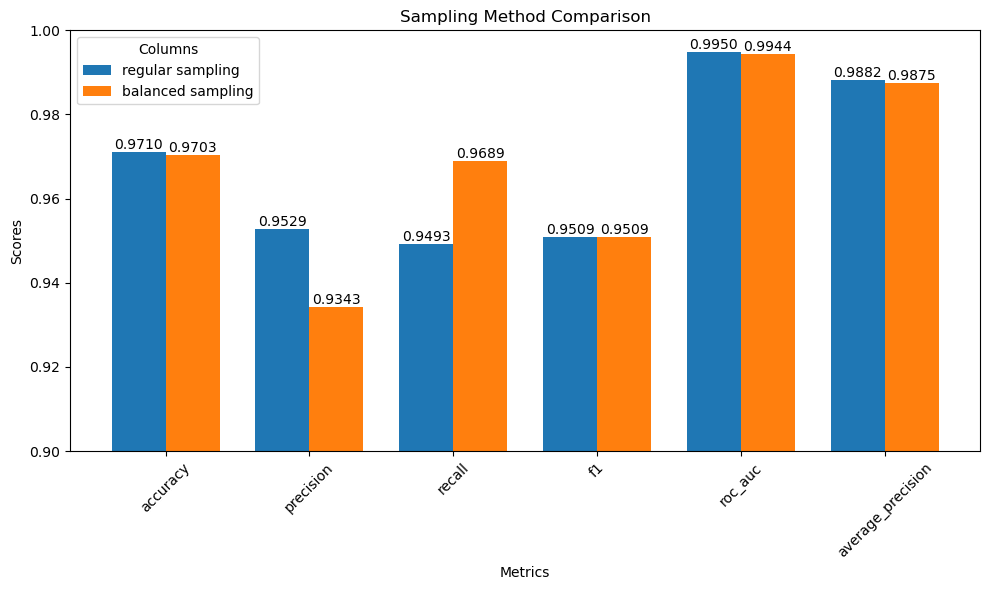

In [1011]:
plot_bar_graphs(pd.concat([reg_agg.T, smote_agg.T]).T,
    columns=['regular sampling', 'balanced sampling'],
    title='Sampling Method Comparison',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.90,  # Adjust these values if needed
    bar_max=1,
    figsize=(10, 6),
    legend=True,
    grid=False,
    decimal=4
)


### Smote Effect: Oversampling the minority & positive class, spam email classification:
1. Precision Decrease: **Increased** # of normal emails incorrectly marked as spam
2. Recall Increase: **Decreased** # of spam emails that sneak into the inbox  
  
  Smote trains with an even split: 50% Spam & 50% non-spam, but the test set has 30% spam emails. The model is better at identifying spam emails, because it trains on more of them, but trains on less (relatively), regular emails. SMOTE sampling ends up catching more regular emails as spam because it has trained on less of them.


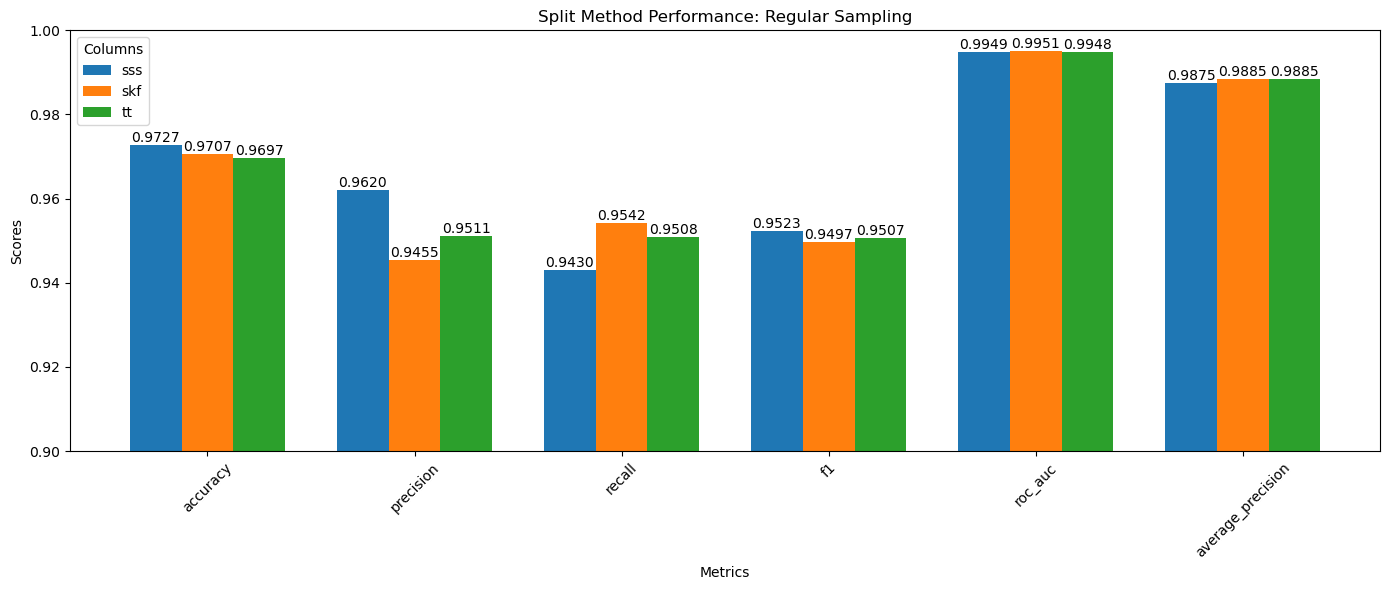

In [1012]:
plot_bar_graphs(split_reg_mean.T,
    columns=['sss','skf','tt'],
    title='Split Method Performance: Regular Sampling',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  # Adjust these values if needed
    bar_max=1,
    figsize=(14, 6),
    legend=True,
    grid=False,
    decimal=4
)


*StratifiedShuffleSplit*: Highest Precision and Highest overall performance.   
*Train Test Split:* 2nd best at everything.  
*StratifiedKFold:* Highest Recall, but lowest overall performance.  

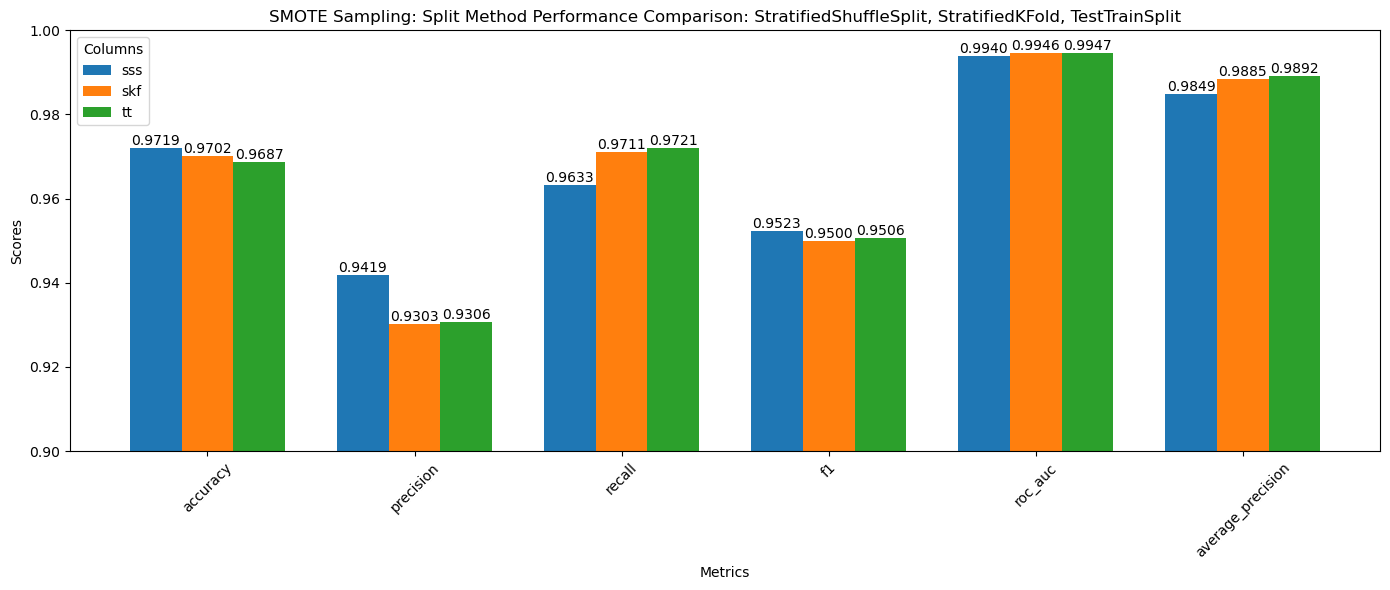

In [1013]:

plot_bar_graphs(split_smote_mean.T,
    columns=['sss','skf','tt'],
    title='SMOTE Sampling: Split Method Performance Comparison: StratifiedShuffleSplit, StratifiedKFold, TestTrainSplit',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  # Adjust these values if needed
    bar_max=1,
    figsize=(14, 6),
    legend=True,
    grid=False,
    decimal=4
)


StratifiedKFold shows overall worse performance. **StratifiedShuffleSplit best performance overall.**

In [1014]:
pr_diffs_sp = pd.DataFrame(split_diffs.T['recall'] + split_diffs.T['precision']).rename(columns={0:'net_change_in_precision_recall'})
pr_diffs_sp = pd.concat([pr_diffs_sp,split_diffs.T[['f1']]],axis=1).rename(columns={'f1':'net_change_in_f1'})

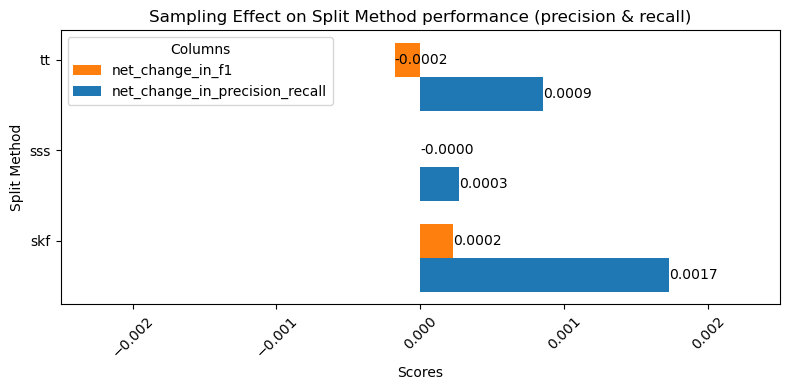

In [1015]:
plot_bar_graphs(pr_diffs_sp,
    columns=pr_diffs_sp.columns,
    title='Sampling Effect on Split Method performance (precision & recall)',
    x_label='Split Method',
    y_label='Scores',
    horizontal=True,  # Set to True if you prefer horizontal bars
    bar_min=-0.0025, # Adjust these values if needed
    bar_max=0.0025,
    figsize=(8,4),
    legend=True,
    grid=False,
    decimal=4
)


SMOTE shows best results with *StratitifiedKFold*. Mildly worse f1 with test_train_split, while showing a stronger gain in precision relative to recall

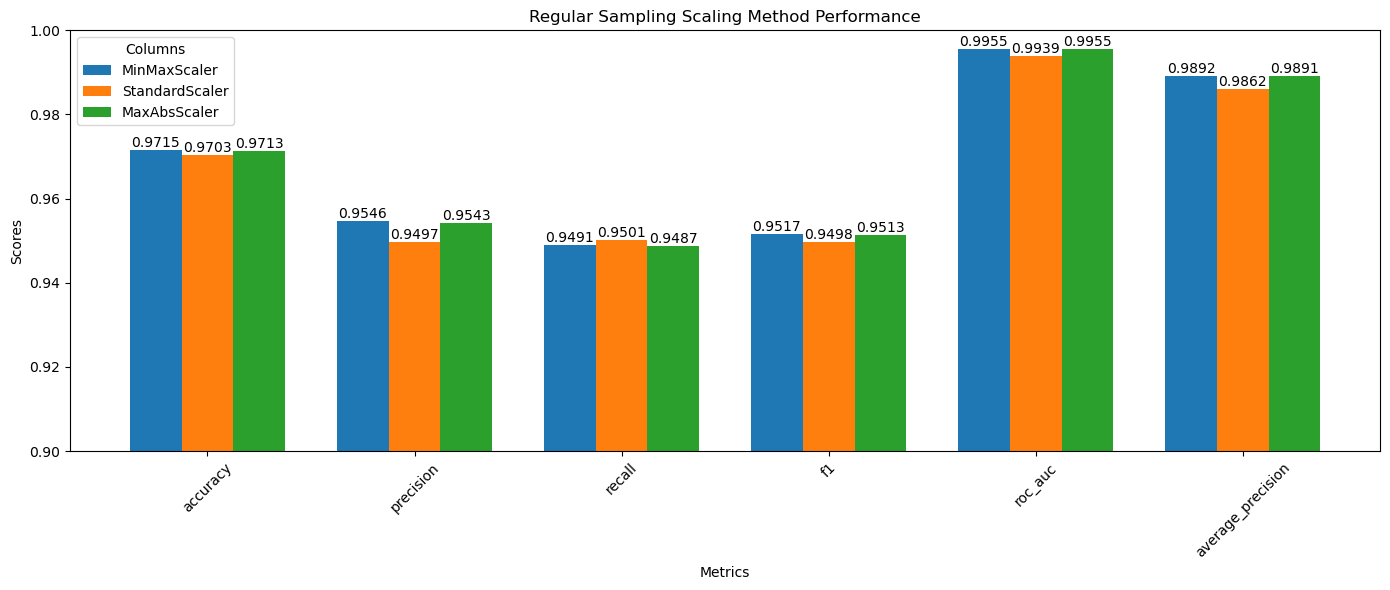

In [1021]:
plot_bar_graphs(scalar_reg_mean.T,
    columns=results_df.scaler.unique().tolist(),
    title='Regular Sampling Scaling Method Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  
    bar_max=1,
    figsize=(14,6),
    legend=True,
    grid=False,
    decimal=4
)


Imbalanced Sampling (non-smote)
>**MinMaxScaler** overall best performance.  
StandardScaler worst performance, despite best recall.  
MaxAbsScaler slightly worst performance than MinMaxScaler in all aspects. 

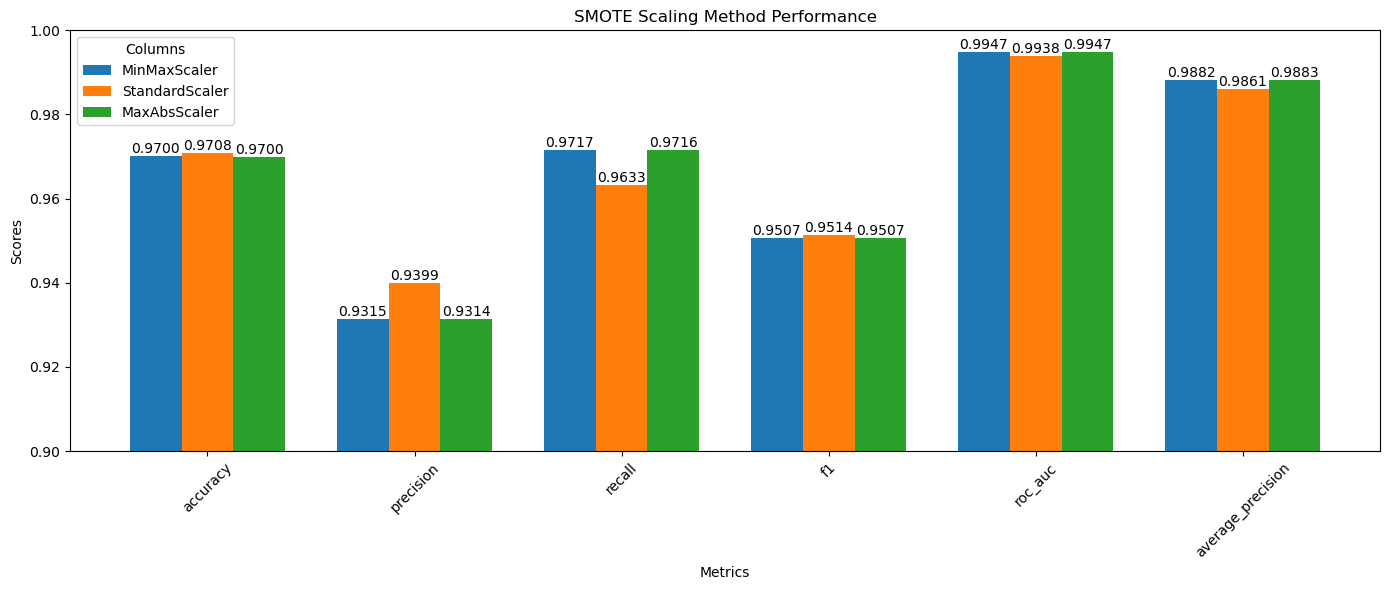

In [1020]:
plot_bar_graphs(scalar_smote_mean.T,
    columns=results_df.scaler.unique().tolist(),
    title='SMOTE Scaling Method Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9,  
    bar_max=1,
    figsize=(14,6),
    legend=True,
    grid=False,
    decimal=4
)               

Balanced Sampling (SMOTE)
>**StandardScaler** overall best performance (f1), highest precision.  
MinMaxScaler highest recall, MaxAbsScaler inferior version in all aspects. 

In [865]:
pr_diffs_sc = pd.DataFrame(scalar_diffs.T['recall'] + scalar_diffs.T['precision']).rename(columns={0:'net_change_in_precision_recall'})
pr_diffs_sc = pd.concat([pr_diffs_sc,scalar_diffs.T[['f1']]],axis=1).rename(columns={'f1':'net_change_in_f1'})

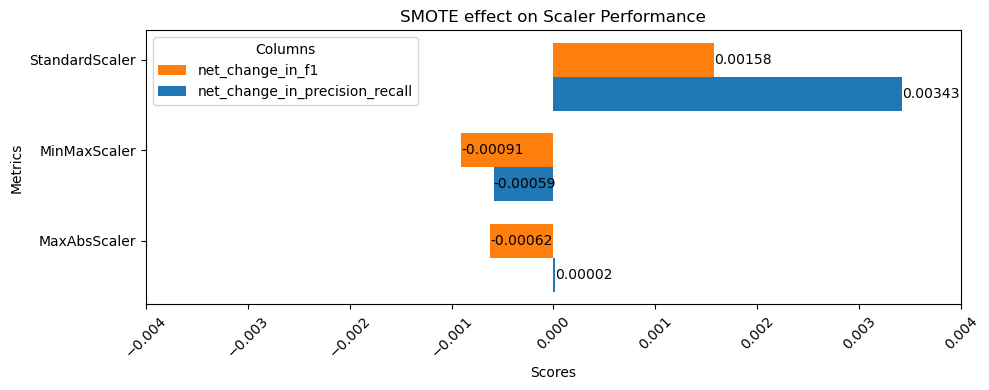

In [1022]:
plot_bar_graphs(pr_diffs_sc,
    columns=pr_diffs_sc.columns,
    title='SMOTE effect on Scaler Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=True,  # Set to True if you prefer horizontal bars
    bar_min=-.004,  # Adjust these values if needed
    bar_max=0.004,
    figsize=(10,4),
    legend=True,
    grid=False,
    decimal=5
)


*SMOTE works best with StandardScaler*, for this word count dataset. Gain in recall outweights loss of precision.

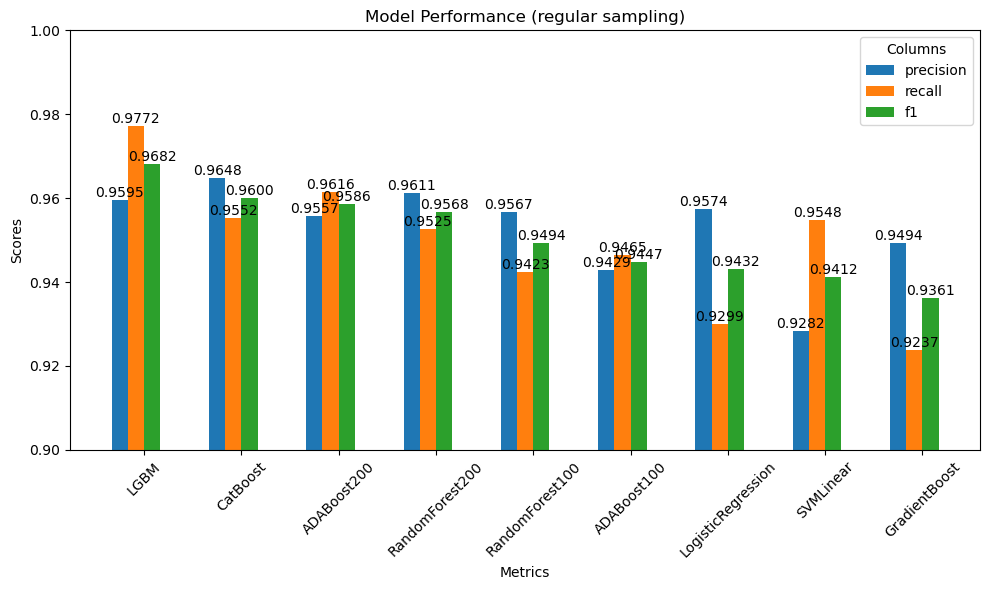

In [1027]:
plot_bar_graphs(model_reg_mean[['f1','recall','precision']].sort_values(by='f1',ascending=False),
    columns=model_reg_mean.columns,
    title='Model Performance (regular sampling)',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9, 
    bar_max=1,
    figsize=(10,6),
    legend=True,
    grid=False,
    decimal=4,
    bar_width=1
)               

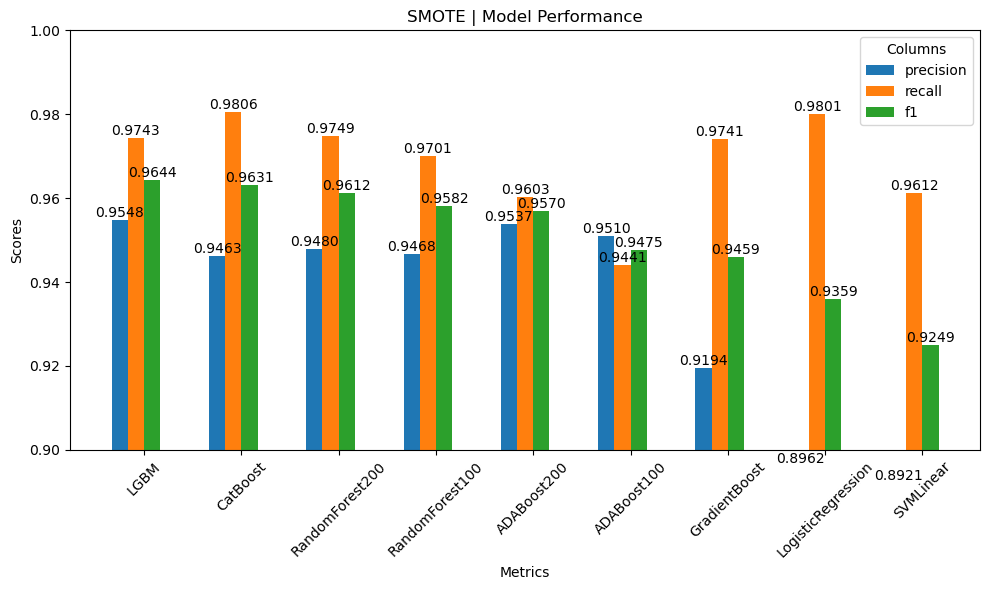

In [1102]:
plot_bar_graphs(model_smote_mean[['f1','recall','precision']].sort_values(by='f1',ascending=False),
    columns=model_smote_mean.columns,
    title='SMOTE | Model Performance',
    x_label='Metrics',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=0.9, 
    bar_max=1,
    figsize=(10,6),
    legend=True,
    grid=False,
    decimal=4,
    bar_width=1
)               

In [891]:
pr_diffs_mod = pd.DataFrame(model_diffs.T['recall'] + model_diffs.T['precision']).rename(columns={0:'net_change_in_precision_recall'})
pr_diffs_mod = pd.concat([pr_diffs_mod,model_diffs.T[['f1']]],axis=1).rename(columns={'f1':'net_change_in_f1'})

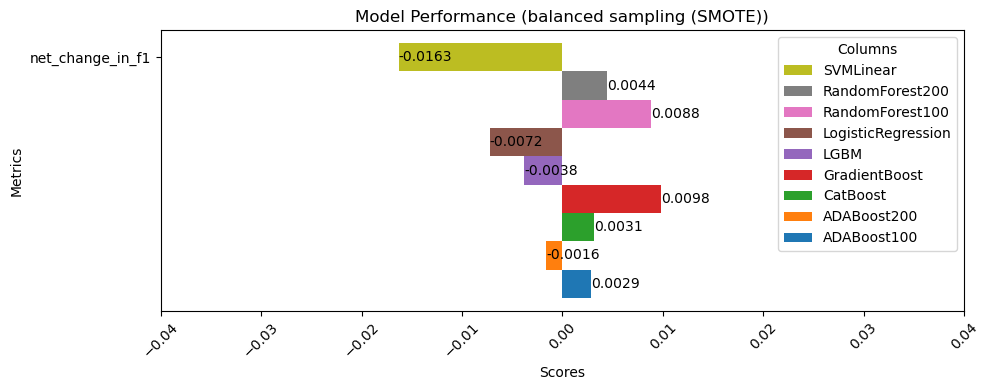

In [1024]:
plot_bar_graphs(pr_diffs_mod[['net_change_in_f1']].sort_values(by='net_change_in_f1', ascending=False).T,
    columns=pr_diffs_mod.T.columns,
    title='Model Performance (balanced sampling (SMOTE))',
    x_label='Metrics',
    y_label='Scores',
    horizontal=True,  # Set to True if you prefer horizontal bars
    bar_min=-0.04, 
    bar_max=0.04,
    figsize=(10,4),
    legend=True,
    grid=False,
    decimal=4
)               

Of the top performing models, Balanced sampling has a positive effect on CatBoost and RandomForest. Has a negative effect on LGBM. 

In [1088]:
results_df['smote'] = 'regular'
smote_df['smote'] = 'smote'

results_df['index'] = results_df.index
smote_df['index'] = smote_df.index

In [1089]:
results_df['index'] = results_df['index'] + '_' + results_df['smote']
results_df = results_df.set_index('index')

smote_df['index'] = smote_df['index'] + '_' + smote_df['smote']
smote_df = smote_df.set_index('index')

In [1090]:
combined_df = pd.concat([results_df, smote_df])

## Precision/Recall Tradeoff
>High Recall / Low Precision Models Less spam in the inbox, but less real emails as well.




>High Precision / Low Recall Models Less real emails caught as spam, more spam in the inbox.

Highly Precise, Less False Positives. False Positives: Regular Email caught as spam  
  High Recall, Less False negatives. False Negative: Spam allowed in Inbox



### High Precision Models
>"Relaxed Spam Filter" Highest number of real emails allowed into inbox (and least real number filtered as spam), but also some spam emails allowed into inbox.

In [1428]:
combined_df.sort_values(by=['precision','recall'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc', 'average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
LogisticRegression_sss_MinMaxScaler_regular,LogisticRegression,0.978723,0.948454,0.920000,0.996109,0.990764
LogisticRegression_sss_MaxAbsScaler_regular,LogisticRegression,0.978723,0.948454,0.920000,0.996109,0.990764
RandomForest200_tt_MaxAbsScaler_regular,RandomForest200,0.977492,0.965079,0.952978,0.996894,0.993439
CatBoost_sss_MinMaxScaler_regular,CatBoost,0.976027,0.962838,0.950000,0.996966,0.991602
CatBoost_sss_StandardScaler_regular,CatBoost,0.976027,0.962838,0.950000,0.996966,0.991602
CatBoost_sss_MaxAbsScaler_regular,CatBoost,0.976027,0.962838,0.950000,0.996966,0.991602
CatBoost_tt_MinMaxScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_StandardScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_MaxAbsScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
LogisticRegression_skf_MinMaxScaler_regular,LogisticRegression,0.972125,0.950596,0.930000,0.994909,0.988190


While Logistic Regression shows highest precision, the recall is a full 3% lower! when taking f1 into account, these three models showed the most promise.

In [1107]:
models_for_selection = ['RandomForest200_tt_MaxAbsScaler_regular', 'CatBoost_sss_MinMaxScaler_regular', 'CatBoost_tt_StandardScaler_regular']

### High Recall Models
>"Aggressive Spam Filter" Highest number of correct spam email classification, but also some real emails are classified as spam. 

In [1427]:
combined_df.sort_values(by=['recall', 'average_precision'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc','average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
LogisticRegression_skf_MinMaxScaler_smote,LogisticRegression,0.881657,0.934169,0.993333,0.994114,0.988283
LogisticRegression_skf_MaxAbsScaler_smote,LogisticRegression,0.881657,0.934169,0.993333,0.994114,0.988283
CatBoost_tt_StandardScaler_smote,CatBoost,0.940299,0.963303,0.987461,0.998459,0.996701
CatBoost_tt_MinMaxScaler_smote,CatBoost,0.943114,0.964778,0.987461,0.998227,0.996190
CatBoost_tt_MaxAbsScaler_smote,CatBoost,0.943114,0.964778,0.987461,0.998227,0.996190
RandomForest200_tt_MaxAbsScaler_smote,RandomForest200,0.942943,0.963190,0.984326,0.996611,0.992473
RandomForest100_tt_MaxAbsScaler_smote,RandomForest100,0.937313,0.960245,0.984326,0.996237,0.990640
LogisticRegression_tt_MinMaxScaler_smote,LogisticRegression,0.862637,0.919473,0.984326,0.989142,0.979755
LogisticRegression_tt_MaxAbsScaler_smote,LogisticRegression,0.862637,0.919473,0.984326,0.989142,0.979754
LGBM_skf_StandardScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998401,0.996162


Again, LogisticRegression sneaks into the top with a low f1, showing flexibility towards both precision and recall, but never both. Erratic fella!

In [1110]:
models_for_selection += ['CatBoost_tt_MinMaxScaler_smote', 'RandomForest200_tt_MaxAbsScaler_smote']

### f1
> Balances precision and recall according to class imbalances in dataset

In [1499]:
combined_df.sort_values(by=['f1','roc_auc'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc']]

,model,precision,f1,recall,roc_auc
LGBM_sss_MinMaxScaler_regular,LGBM,0.966887,0.970100,0.973333,0.997351
LGBM_sss_StandardScaler_regular,LGBM,0.966887,0.970100,0.973333,0.997351
LGBM_sss_MaxAbsScaler_regular,LGBM,0.966887,0.970100,0.973333,0.997351
LGBM_skf_StandardScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998401
LGBM_skf_MinMaxScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397
LGBM_skf_MaxAbsScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397
CatBoost_tt_MinMaxScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183
CatBoost_tt_StandardScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183
CatBoost_tt_MaxAbsScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183
ADABoost200_tt_MinMaxScaler_regular,ADABoost200,0.957055,0.967442,0.978056,0.997680


### ROC_AUC
>False Positive Rate on x-axis. True Positive Rate on y-axis. Area under the curve. 

In [1430]:
combined_df.sort_values(by=['roc_auc','recall'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc', 'average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
LGBM_skf_MaxAbsScaler_smote,LGBM,0.954545,0.967105,0.980000,0.998642,0.996682
LGBM_skf_MinMaxScaler_smote,LGBM,0.954545,0.967105,0.980000,0.998583,0.996540
CatBoost_tt_StandardScaler_smote,CatBoost,0.940299,0.963303,0.987461,0.998459,0.996701
LGBM_skf_StandardScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998401,0.996162
LGBM_skf_MinMaxScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397,0.996150
LGBM_skf_MaxAbsScaler_regular,LGBM,0.954693,0.968801,0.983333,0.998397,0.996150
LGBM_skf_StandardScaler_smote,LGBM,0.942122,0.959083,0.976667,0.998370,0.996002
CatBoost_skf_StandardScaler_smote,CatBoost,0.945513,0.964052,0.983333,0.998243,0.995797
CatBoost_tt_MinMaxScaler_smote,CatBoost,0.943114,0.964778,0.987461,0.998227,0.996190
CatBoost_tt_MaxAbsScaler_smote,CatBoost,0.943114,0.964778,0.987461,0.998227,0.996190


In [1431]:
models_for_selection += ['LGBM_skf_MaxAbsScaler_smote', 'CatBoost_tt_StandardScaler_smote']

### Highest Average Precision
>Highest area under the curve when plotting recall on x-axis and precision on y-axis.

In [1422]:
combined_df.sort_values(by=['average_precision','f1'],ascending=False).head(10)[['model','precision','f1','recall','roc_auc', 'average_precision']]

,model,precision,f1,recall,roc_auc,average_precision
CatBoost_tt_StandardScaler_smote,CatBoost,0.940299,0.963303,0.987461,0.998459,0.996701
LGBM_skf_MaxAbsScaler_smote,LGBM,0.954545,0.967105,0.980000,0.998642,0.996682
LGBM_skf_MinMaxScaler_smote,LGBM,0.954545,0.967105,0.980000,0.998583,0.996540
CatBoost_tt_MinMaxScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_StandardScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
CatBoost_tt_MaxAbsScaler_regular,CatBoost,0.974603,0.968454,0.962382,0.998183,0.996267
LGBM_tt_MinMaxScaler_regular,LGBM,0.956923,0.965839,0.974922,0.998152,0.996256
LGBM_tt_StandardScaler_regular,LGBM,0.956923,0.965839,0.974922,0.998152,0.996256
LGBM_tt_MaxAbsScaler_regular,LGBM,0.956923,0.965839,0.974922,0.998152,0.996256
CatBoost_tt_MinMaxScaler_smote,CatBoost,0.943114,0.964778,0.987461,0.998227,0.996190


Curiously, the top 3 are the same as ROC_AUC top models. Average Precision would correlate with TPR/FPR.

In [1432]:
models_for_selection += ['LGBM_sss_MinMaxScaler_regular', 'LGBM_skf_StandardScaler_regular']
models_for_selection

['RandomForest200_tt_MaxAbsScaler_regular',
 'CatBoost_sss_MinMaxScaler_regular',
 'CatBoost_tt_StandardScaler_regular',
 'CatBoost_tt_MinMaxScaler_smote',
 'RandomForest200_tt_MaxAbsScaler_smote',
 'LGBM_sss_MinMaxScaler_regular',
 'LGBM_skf_StandardScaler_regular',
 'LGBM_skf_MaxAbsScaler_smote',
 'CatBoost_tt_StandardScaler_smote']

In [1603]:
top_models = combined_df[combined_df.index.isin(models_for_selection)]
top_models.sort_values(by='average_precision', ascending=False)

,accuracy,precision,recall,f1,roc_auc,precision_recall,average_precision,roc_curve,model,split_method,scaler,smote
CatBoost_tt_StandardScaler_smote,0.976812,0.940299,0.987461,0.963303,0.998459,"(array([0.30821256, 0.30851064, 0.30880929, 0....",0.996701,"(array([0. , 0. , 0. , 0....",CatBoost,tt,StandardScaler,smote
LGBM_skf_MaxAbsScaler_smote,0.980658,0.954545,0.980000,0.967105,0.998642,"(array([0.2901354 , 0.29041626, 0.29069767, 0....",0.996682,"(array([0. , 0. , 0. , 0....",LGBM,skf,MaxAbsScaler,smote
CatBoost_tt_StandardScaler_regular,0.980676,0.974603,0.962382,0.968454,0.998183,"(array([0.30821256, 0.30851064, 0.30880929, 0....",0.996267,"(array([0. , 0. , 0. , 0....",CatBoost,tt,StandardScaler,regular
CatBoost_tt_MinMaxScaler_smote,0.977778,0.943114,0.987461,0.964778,0.998227,"(array([0.30821256, 0.30851064, 0.30880929, 0....",0.996190,"(array([0. , 0. , 0. , 0....",CatBoost,tt,MinMaxScaler,smote
LGBM_skf_StandardScaler_regular,0.981625,0.954693,0.983333,0.968801,0.998401,"(array([0.2901354 , 0.29041626, 0.29069767, 0....",0.996162,"(array([0. , 0. , 0. , 0....",LGBM,skf,StandardScaler,regular
RandomForest200_tt_MaxAbsScaler_regular,0.978744,0.977492,0.952978,0.965079,0.996894,"(array([0.30821256, 0.35054945, 0.36540664, 0....",0.993439,"(array([0. , 0. , 0. , 0....",RandomForest200,tt,MaxAbsScaler,regular
LGBM_sss_MinMaxScaler_regular,0.982609,0.966887,0.973333,0.970100,0.997351,"(array([0.28985507, 0.2901354 , 0.29069767, 0....",0.992969,"(array([0. , 0. , 0. , 0....",LGBM,sss,MinMaxScaler,regular
RandomForest200_tt_MaxAbsScaler_smote,0.976812,0.942943,0.984326,0.963190,0.996611,"(array([0.30821256, 0.34337998, 0.35682327, 0....",0.992473,"(array([0. , 0. , 0. , 0....",RandomForest200,tt,MaxAbsScaler,smote
CatBoost_sss_MinMaxScaler_regular,0.978744,0.976027,0.950000,0.962838,0.996966,"(array([0.28985507, 0.2901354 , 0.29041626, 0....",0.991602,"(array([0. , 0. , 0. , 0....",CatBoost,sss,MinMaxScaler,regular


## ROC-AUC Plots
>Visualization of the number of real emails caught as spam, on the x-axis, relative to the number of spam emails caught as spam 

In [1443]:
ids = ['CatBoost_sss_MinMaxScaler_regular', 'CatBoost_tt_StandardScaler_regular','LGBM_skf_StandardScaler_regular','CatBoost_tt_StandardScaler_smote']

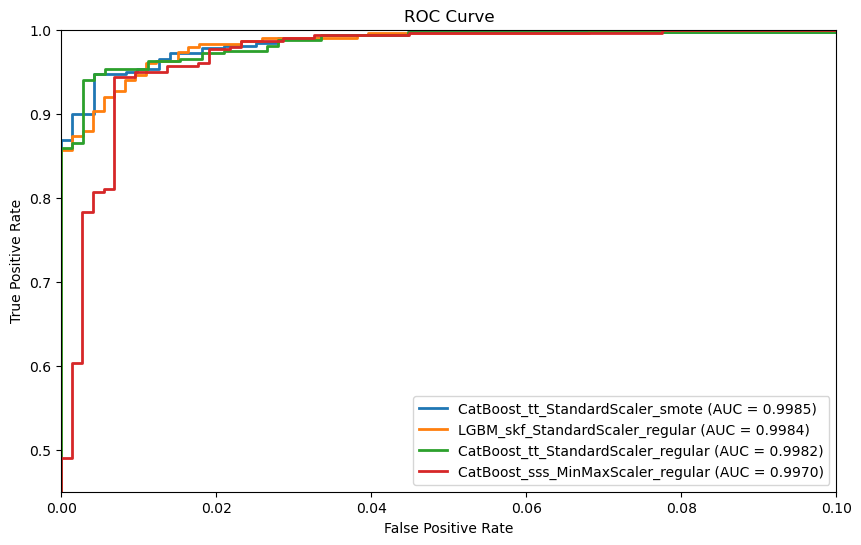

In [1448]:
plt.figure(figsize=(10, 6))

for idx, row in top_models[top_models.index.isin(ids)].sort_values(by='roc_auc', ascending=False).iterrows():
    fpr, tpr, row_t = string_array_split(row['roc_curve'])
    roc_auc = row['roc_auc']
    label=idx
    plot_roc_curve(fpr, tpr, roc_auc,x_max = 0.1, y_min=0.45, label=label)

Blue line vs. Red: Smote increases the performance of the top-performing CatBoost model.

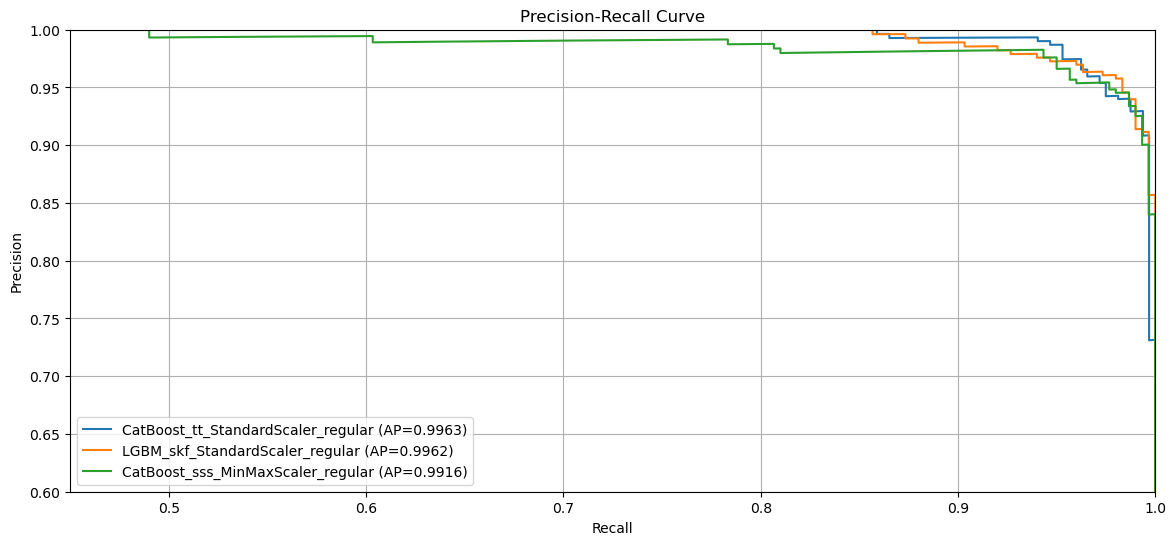

In [1444]:
plt.figure(figsize=(14, 6)) 

for idx, row in top_models[top_models.index.isin(ids[:3])].sort_values(by='average_precision', ascending=False).iterrows():
    pr = string_array_split(row['precision_recall'])
    ap = row['average_precision']
    plot_pr_curve(pr, ap, x_min=0.45, y_min=0.6, label=idx)
    
plt.show()

#### Precision Loss
>The CatBoost_MinMaxScaler_sss model, the green line, incorrectly classifies a non-spam email, a false positive, a lot earlier than the other two. No matter the threshold set, this model would be basically guaranteed to classify a normal email as spam. 

CatBoost_tt_StandardScaler has the highest average precision, but, LGBM_skf_StandardScaler is not far behind. The cost of 0.0001 average precision is likely worth the cost for having a much stronger recall. The right side of the graph shows where the model is able to classify 0 spam emails as non-spam. In order for the top performing model, blue, it would do so at a precision of 0.725! This model is not ideal for a high recall model, and in fact, underperforms the lowest Average Precision, the green line, if you wanted a model that would NEVER classify a spam email as non-spam.   

### Inflection Points on PR Curve Analysis:

In [1500]:
diff_dc = df_to_diff_dc(combined_df)

In [1581]:
perfect_precision = {}
perfect_recall = {}
top_f1s = {}

top_99_rec = {}
top_99_pre = {}

for k,v in diff_dc.items():
    if not v[v['precision'] == 1].empty:
        perfect_precision[k] = v.loc[v['precision'] == 1, 'f1'].values[0]
 
    if not v[v['recall'] == 1].empty:
        perfect_recall[k] = v.loc[v['recall'] == 1, 'f1'].values[0]
   
    top_f1s[k] = v['f1'].max()

    if not v[v['recall'] > 0.99].empty:
        top_99_rec[k] = v.loc[v['recall'] > 0.99, 'f1'].values[0]
    if not v[v['precision'] > 0.99].empty:        
        top_99_pre[k] = v.loc[v['precision'] > 0.99, 'f1'].values[0]    

### Top f1 scores threshold instances

In [1560]:
best_f1_scores = pd.DataFrame.from_dict(threshold_k_idx,orient='index').rename(columns={0:'max_f1'}).sort_values(by='max_f1',ascending=False)#.head(15)
best_f1_scores.head(5)

,max_f1
LGBM_tt_MinMaxScaler_regular,0.973144
LGBM_tt_StandardScaler_regular,0.973144
LGBM_tt_MaxAbsScaler_regular,0.973144
ADABoost200_tt_MinMaxScaler_regular,0.972308
ADABoost200_tt_StandardScaler_regular,0.972308


### With 100% recall: top f1-scores:

In [1604]:
best_recall = pd.DataFrame.from_dict(perfect_recall,orient='index').rename(columns={0:'max_f1'}).sort_values(by='max_f1',ascending=False)#.head(15)
best_recall.head(5)

,max_f1
LGBM_skf_MaxAbsScaler_smote,0.961538
LGBM_skf_MinMaxScaler_smote,0.961538
LGBM_skf_StandardScaler_smote,0.956938
ADABoost200_tt_StandardScaler_regular,0.952239
ADABoost200_tt_MaxAbsScaler_regular,0.952239


99% or better recall:

In [1605]:
top_rec = pd.DataFrame.from_dict(top_99_rec,orient='index').rename(columns={0:'max_f1'}).sort_values(by='max_f1',ascending=False)#.head(15)
top_rec.head(5)

,max_f1
ADABoost200_tt_MinMaxScaler_regular,0.972308
ADABoost200_tt_StandardScaler_regular,0.972308
ADABoost200_tt_MaxAbsScaler_regular,0.972308
RandomForest200_sss_StandardScaler_regular,0.969106
CatBoost_tt_MinMaxScaler_smote,0.966463


### With 100% precision: top f1-scores:

In [1606]:
best_precision = pd.DataFrame.from_dict(perfect_precision,orient='index').rename(columns={0:'max_f1'}).sort_values(by='max_f1',ascending=False)#.head(15)
best_precision.head(5)

,max_f1
CatBoost_tt_StandardScaler_smote,0.929530
LGBM_tt_StandardScaler_smote,0.927731
LGBM_tt_MinMaxScaler_regular,0.925926
LGBM_tt_StandardScaler_regular,0.925926
LGBM_tt_MaxAbsScaler_regular,0.925926


### Highest Average Precision: 'CatBoost_tt_StandardScaler_smote'

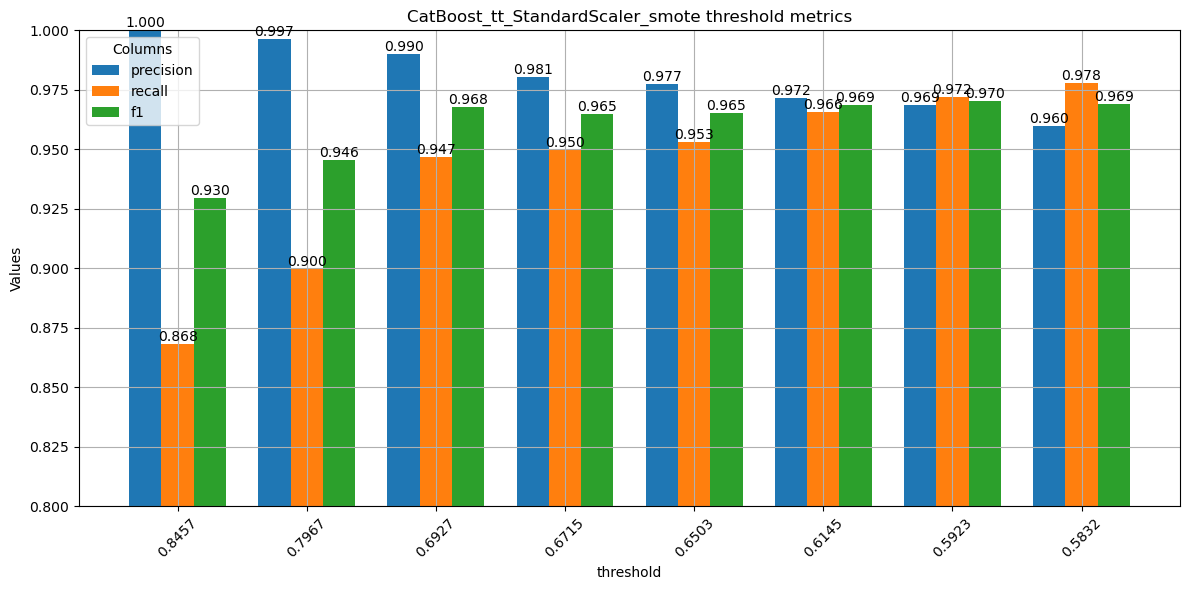

In [1591]:
plot_bar_graphs(diff_dc['CatBoost_tt_StandardScaler_smote'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='CatBoost_tt_StandardScaler_smote threshold metrics', horizontal=False, bar_min=0.8, figsize=(12,6))

#### Highest f1-score: 0.970
>SMOTE, despite increasing recall overall, creates a pretty good model that never classifies a non-spam email as spam, that is, with perfect 100% precision. The cost: 13.2% of spam emails allowed in the inbox with an f1-score of .930. Choosing lower precision thresholds show f1-score peaks at a threshold of 69.27% with 0.968 and then slowly rises, peaking again, forming a bimodal model. 

#### The most viable model selection for precisions above 99.0%. 


##### Same Model Without Smote:

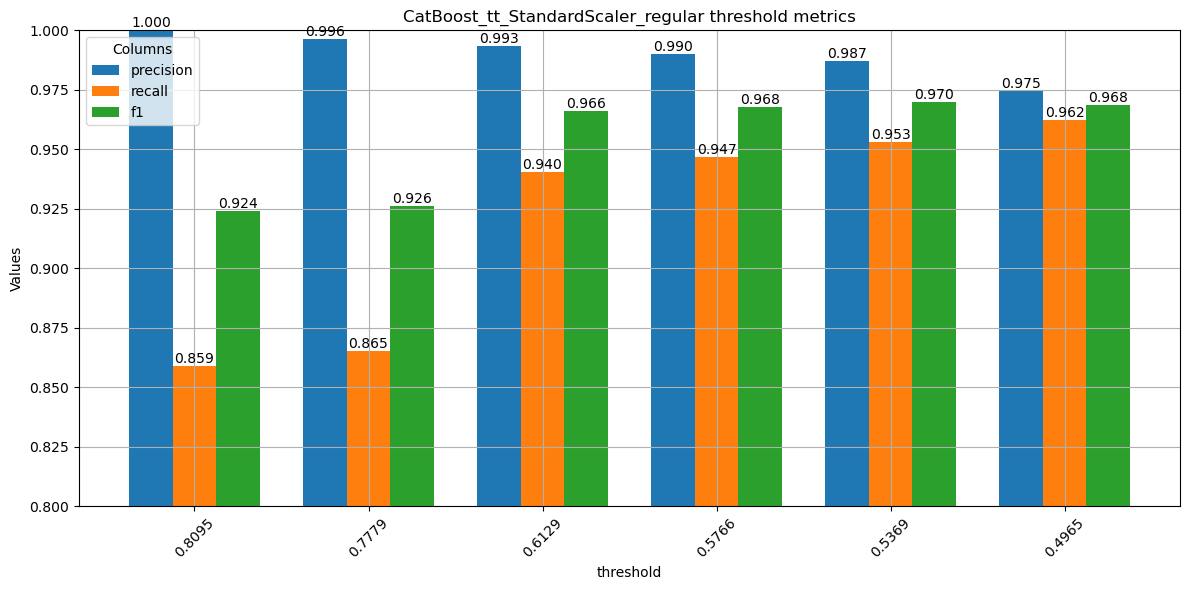

In [1455]:
plot_bar_graphs(diff_dc['CatBoost_tt_StandardScaler_regular'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(6), 
['precision','recall','f1'], title ='CatBoost_tt_StandardScaler_regular threshold metrics', horizontal=False, bar_min=0.8, figsize=(12,6))

### f1-score Increase: 0.926 => 0.966.  
>Recall increases 7.5%, while precision only decreases 0.03%, meaning 7.5% less spam can be allowed in the inbox at a cost of 0.03% more normal emails being marked as spam.  

This is a valuable, steep tradeoff that is highly indicative of the best way to tune this model for this data.

### Top Recall: LGBM_skf_MaxAbsScaler_smote

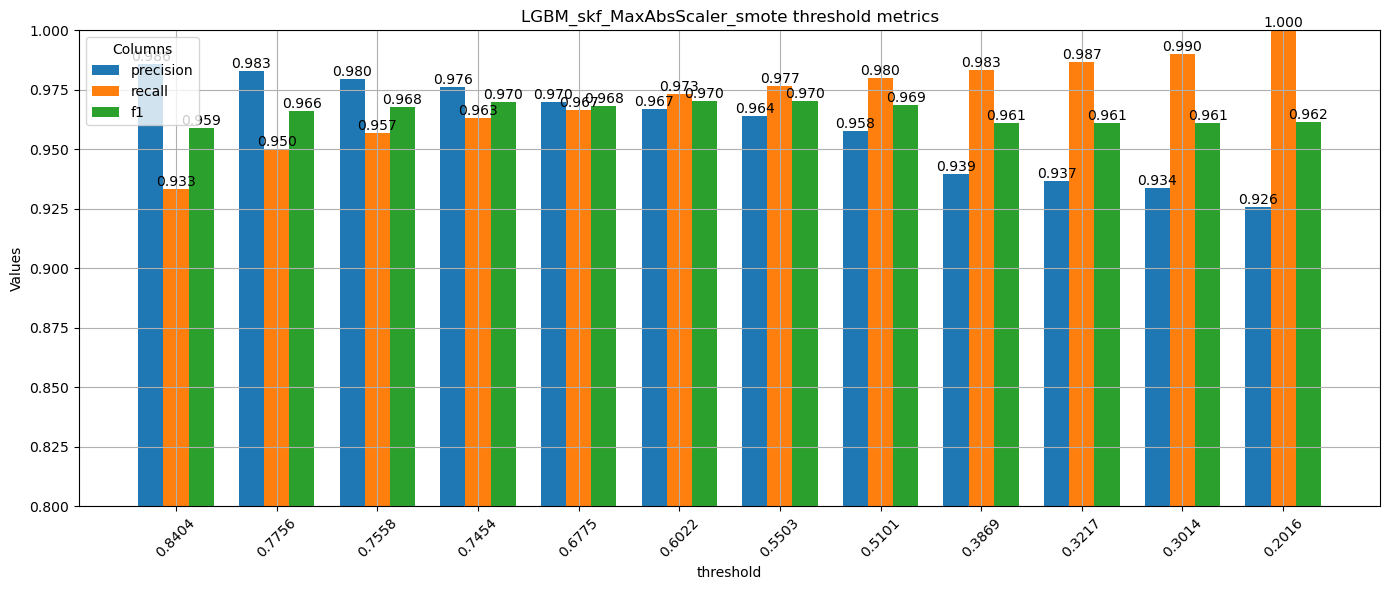

In [1556]:
plot_bar_graphs(diff_dc['LGBM_skf_MaxAbsScaler_smote'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(12), 
['precision','recall','f1'], title ='LGBM_skf_MaxAbsScaler_smote threshold metrics', horizontal=False, bar_min=0.8, figsize=(14,6))

Best model with Perfect Recall: 
>92.6% precision: 7.4% of real emails misclassified as spam. f1-score: 0.962.

### Top Performer: f1 score

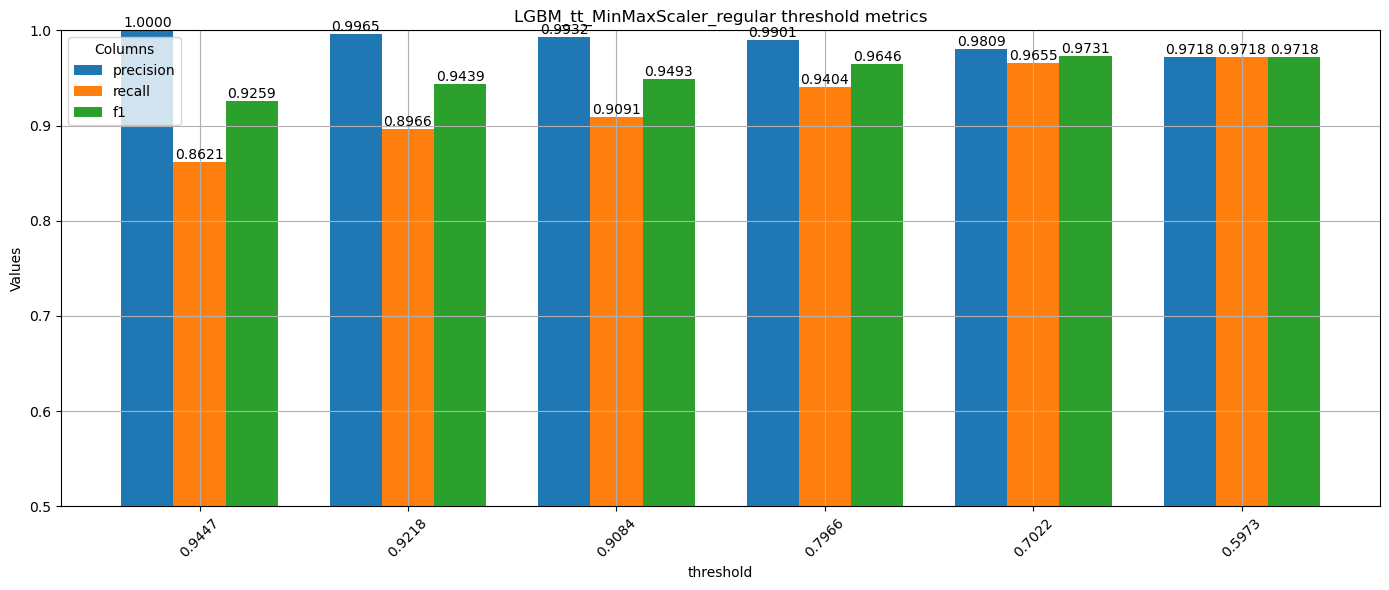

In [1601]:
plot_bar_graphs(diff_dc['LGBM_tt_MinMaxScaler_regular'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(6), ['precision','recall','f1'],
    title ='LGBM_tt_MinMaxScaler_regular threshold metrics', horizontal=False, bar_min=0.5,decimal=4, figsize=(14,6))

##### Highest f1 score: 0.9731
>*Precision:* 0.9809  
*Recall:* 0.9655   
3.45% of spam emails in inbox, 1.91% of regular emails marked as spam


# Model Comparisons

## 100% Precision Model:
  >CatBoost_tt_StandardScaler_smote  
    
Will never allow a regular email to be marked as spam  
Tradeoff: 13.17% of spam allowed in the inbox  
f1: 0.929

In [1574]:
best_precision_model = diff_dc['CatBoost_tt_StandardScaler_smote']
best_precision_model[best_precision_model['precision'] > 0.99][['threshold','precision','recall','f1']].set_index('threshold')

,precision,recall,f1
threshold,,,
0.8457,1.000000,0.868339,0.929530
0.7967,0.996528,0.899687,0.945634
0.6927,0.990164,0.946708,0.967949


#### High Precision Model

Additionally, the f1-score of 0.929 can be improved upon to **0.968**  
Tradeoff: 0.84% of regular emails to be marked as spam and 4.54% of spam emails in the inbox. 

## 100% Recall Model: 
>LGBM_skf_MaxAbsScaler_smote  
  
Will never allow a spam email to be allowed in the inbox  
Tradeoff: 7.41% of regular emails marked as spam  
f1: 0.9615

In [1599]:
best_recall = diff_dc['LGBM_skf_MaxAbsScaler_smote']
best_recall[best_recall['recall'] > .99].sort_values(by='recall',ascending=False)[['threshold','precision','recall','f1']].set_index('threshold')

,precision,recall,f1
threshold,,,
0.2016,0.925926,1.0,0.961538


## Highest f1-score (overall performance): 
>LGBM_tt_MinMaxScaler_regular  

Tradeoff: 2.01% of regular emails marked as spam, 3.45% of spam emails allowed in inbox  
f1: 0.9731

In [1602]:
best_f1 = diff_dc['LGBM_tt_MinMaxScaler_regular']
best_f1[best_f1['f1'] > .972].sort_values(by='recall',ascending=False)[['threshold','precision','recall','f1']].set_index('threshold')

,precision,recall,f1
threshold,,,
0.7022,0.980892,0.965517,0.973144


In [1272]:
def string_array_split(s):
    # Regular expression to match numpy array patterns
    pattern = r'array\(\[(.*?)\]\)'
    
    # Find all matches in the string
    matches = re.findall(pattern, s, re.DOTALL)

    arrays = []
    for match in matches:
        # Clean up the match to remove unwanted characters
        clean_match = match.replace('\n', '').replace(' ', '')
        
        # Convert the cleaned string into a list of numbers
        try:
            # Handle both float and scientific notation numbers
            number_list = [float(num) for num in clean_match.split(',') if num]
            array = np.array(number_list)
            arrays.append(array)
        except ValueError as e:
            print(f"Error converting to array: {e}")

    return arrays


In [631]:
import matplotlib.pyplot as plt

def plot_two_bar_graphs(df1, df2, columns, labels=['df1', 'df2'], title='Model Performance Comparison', x_label=None, y_label='Values',
                        horizontal=False, bar_min=0.90, bar_max=1.00, figsize=(14, 8), legend=True, grid=True, decimal=3,
                        group_spacing=0.1, bar_width=0.3):
    if x_label is None:
        x_label = 'Index'
    
    num_cols = len(columns)
    width = bar_width / 2  # Adjust width for two sets of bars
    x = range(len(df1))  # X positions for bars based on number of indices

    # Adjust spacing between groups
    group_width = width * 2 + group_spacing
    plt.figure(figsize=figsize)
    
    # Collect handles and labels for the legend
    handles = []
    legend_labels = [labels[0], labels[1]]  # Legend only shows dataset names

    if horizontal:
        # Plot bars for both DataFrames
        for i, col in enumerate(columns):
            if col in df1.columns and col in df2.columns:
                offset = group_width * i
                bars1 = plt.barh([p + offset - width / 2 for p in x], df1[col], height=width, color='#1f77b4', label=labels[0])  # Dark Blue
                bars2 = plt.barh([p + offset + width / 2 for p in x], df2[col], height=width, color='#ff7f0e', label=labels[1])  # Dark Orange
                
                # Collect handles
                handles.extend([bars1[0], bars2[0]])
                
                for bar in bars1:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)

                for bar in bars2:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)
                
        plt.xlabel(y_label)
        plt.ylabel(x_label)
        plt.yticks(ticks=[p + group_width * (num_cols - 1) / 2 for p in x], labels=df1.index)
        plt.xticks(rotation=45)
        plt.xlim(left=bar_min, right=bar_max)

    else:
        # Plot bars for both DataFrames
        for i, col in enumerate(columns):
            if col in df1.columns and col in df2.columns:
                offset = group_width * i
                bars1 = plt.bar([p + offset - width / 2 for p in x], df1[col], width=width, color='#1f77b4', label=labels[0])  # Dark Blue
                bars2 = plt.bar([p + offset + width / 2 for p in x], df2[col], width=width, color='#ff7f0e', label=labels[1])  # Dark Orange
                
                # Collect handles
                handles.extend([bars1[0], bars2[0]])
                
                for bar in bars1:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)

                for bar in bars2:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)
                
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(ticks=[p + group_width * (num_cols - 1) / 2 for p in x], labels=df1.index, rotation=45)
        plt.ylim(bottom=bar_min, top=bar_max)
    
    plt.title(title)
    if legend:
        plt.legend(handles=handles, labels=legend_labels, title='Datasets')
    plt.grid(grid)
    plt.tight_layout()
    
    plt.show()


In [177]:
def df_to_diff_dc(df):
    pr_curve_dc = {}
    precision_drop_dc = {}

    for idx, row in df.iterrows():
        pr_curve_dc[idx] = create_pr_df(row)[0]
        precision_drop_dc[idx] = create_pr_df(row)[1]

    diffs = create_diff_within(precision_drop_dc)  
    return diffs

In [178]:
def create_diff_within(dc):
    for k,v in dc.items():
        v['precision_diff'] = v['precision'].diff().fillna(0)
        v['recall_diff'] = v['recall'].diff().fillna(0)
        v['f1'] = 2 * (v['precision'] * v['recall']) / (v['precision'] + v['recall'] + 1e-10) 
        v['threshold'] = round(v['threshold'],4)
        v = v.reset_index(drop=True).set_index('threshold')
    return dc

In [1371]:
def create_pr_df(row):

    cb_p, cb_r, cb_th = string_array_split(row['precision_recall'])
    
    cb_r = cb_r
    cb_p = cb_p
    cb_th = np.append(0, cb_th)

    cb_pr_df = pd.DataFrame({
    'threshold': cb_th,
    'precision': cb_p,
    'recall': cb_r
    })
    
    return cb_pr_df, cb_pr_df[cb_pr_df.index.isin(find_drops(cb_p))].sort_values(by='precision', ascending=False)

In [180]:
def find_drops(y):
  
    diffs = np.diff(y)
    
    return np.where(np.diff(np.sign(diffs)) < 0)[0] + 1


In [764]:
import matplotlib.pyplot as plt

def plot_bar_graphs(df, columns, title='Model Performance Comparison', x_label=None, y_label='Values', 
                     horizontal=False, bar_min=0.90, bar_max=1.00, figsize=(14, 8), legend=True, 
                     grid=True, decimal=3, bar_width=0.75):
    if x_label is None:
        x_label = df.index.name if df.index.name is not None else 'Index'

    num_cols = len(columns)
    width = bar_width / num_cols  # Use the bar_width parameter
    x = range(len(df))
    
    plt.figure(figsize=figsize)
    
    # Collect handles and labels for the legend
    handles = []
    labels = []
    
    if horizontal:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.barh([p + offset for p in x], df[col], height=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)
                
        plt.xlabel(y_label)
        plt.ylabel(x_label)
        plt.yticks(ticks=[p + width * ((num_cols - 1) / 2) for p in x], labels=df.index)
        plt.xticks(rotation=45)
        plt.xlim(left=bar_min, right=bar_max)

    else:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.bar([p + offset for p in x], df[col], width=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(ticks=[p for p in x], labels=df.index, rotation=45)
        plt.ylim(bottom=bar_min, top=bar_max)
    
    plt.title(title)
    if legend:
        # Reverse the order of handles and labels if the plot is horizontal
        if horizontal:
            handles = handles[::-1]
            labels = labels[::-1]
        plt.legend(handles=handles, labels=labels, title='Columns')
    plt.grid(grid)
    plt.tight_layout()
    
    plt.show()


In [1258]:
def plot_roc_curve(fpr, tpr, roc_auc, title='ROC Curve', x_min=0, x_max = 0.125, y_min=0.875, y_max=1.0, label=None):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')


In [1133]:
def plot_pr_curve(precision_recall, average_precision, title='Precision-Recall Curve', x_min=0.75, x_max=1.0, y_min=0.75, y_max=1, label=None):

    precision, recall, _ = precision_recall

    plt.plot(recall, precision, label=f'{label} (AP={average_precision:.4f})')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

In [176]:
def rp_curve(df, idx):

    p_arr = df.loc[idx,'precision_recall'][0]
    r_arr = df.loc[idx,'precision_recall'][1]
    th_arr = df.loc[idx,'precision_recall'][2]
    avg_r = np.mean(r_arr)
    plot_pr_curve((r_arr,p_arr,th_arr), avg_r, title='Initial Precision Drops', x_min=0.75,x_max=1, y_min=0.75, label=idx)